# ECE 157B/272B Homework 4

#### Submission by: Juan Mendoza-Martinez

#Describe our audio preprocessing at a high level.


The audio processing step takes all the sound clips and makes them all one consistent length because the network bottoms are not trained on varying length clips. Next, each clip is analyzed using a function to scan through an identify the frequency components of the sound clip using fourier-transform at varying windows of the clip. 

# Is there a connection between the number of trainable  parameters and the speed of network training? If so, does increasing the trainable parameter count cause training to speed up or slow down?

Based on data and observations, there is a connection between the number of trainable parameters and speed of network training. Increasing the trainable parameter will cause the speed to slow.

# How did setting the ”bottom” to non-trainable affect the training speed?

Setting the bottom to non-trainable sped up the training speed.

# In your own words, what is being transferred by transfer learning for this specific problem?

For this specific problem, Google Speech Commands are being transferred with pretrained models to a smaller dataset of spoken_digit.

#  In your own words, what is being transferred by transfer learning in general?

A model with pretrained data is used in addition to a new model that is using data familiar to the one used in the pretrained model.

First, we'll import our commonly-used packages:

In [45]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import numpy as np

To load the *spoken_digit* dataset, you'll need to have the package **pydub** installed. That's what this shell line does:

In [2]:
!pip install pydub

# Loading
To ease loading the dataset from TensorflowDatasets, this function extracts just the audio and label from the content provided, and lets you specify the splits (e.g. train/test) that are loaded:

In [3]:
def load_ds(ds:str, splits=['train','test']):
    @tf.function(autograph=False)
    def make_supervised(dat):
        return dat['audio'],dat['label']

    splits = tfds.load(ds,split=splits,try_gcs=True)

    return [split.map(make_supervised) for split in splits]

Because *spoken_digit* only provides a training dataset, we need to split that dataset into train, validation, and test for our own purposes. This tells Tensorflow Datasets to do that for us.

In [4]:
raw_train, raw_val, raw_test = \
    load_ds('spoken_digit', 
            splits=['train[:80%]','train[80%:90%]','train[90%:]'])

Shuffling and writing examples to /root/tensorflow_datasets/spoken_digit/1.0.9.incompleteDFD077/spoken_digit-train.tfrecord


Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.


# Preprocessing

Next, we need to take our data of unknown length and fix it to some fixed lengths, so that we can use convolutional neural networks on it.

(An alternate approach is to use a recurrent neural network, LSTM, or self-attention to deal with the varying lengths. However, *Google Speech Commands* had fixed-length audio files, so our network bottoms weren't trained with varying lengths in mind!)

Below is a function to fix each dataset to 8000 samples, aka one second:

In [5]:
target_sample_count = 8000

@tf.function(experimental_relax_shapes=True)
def fix_8k_length(waveform, label):
    # Pad samples with less than 8000 samples, truncate longer
    waveform = tf.cast(waveform,tf.float32)
    target_samp_count = tf.constant(target_sample_count,tf.int32)
    samp_count = tf.shape(waveform)[0]
    if samp_count >= target_samp_count:
        waveform = tf.slice(waveform,(0,),(target_samp_count,))
    else:
        waveform = tf.pad(waveform,[(0,target_samp_count-samp_count)])
        
    return tf.ensure_shape(waveform,shape=(target_sample_count,)), label

We then apply this function to each of our datasets:

In [6]:
fixed_train = raw_train.map(fix_8k_length)
fixed_val = raw_val.map(fix_8k_length)
fixed_test = raw_test.map(fix_8k_length)

Now that they're all the same length and easier to work with, let's take a look at some of these waveforms:

4
[8000]


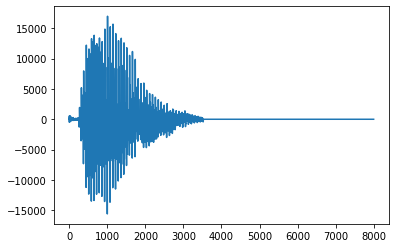

3
[8000]


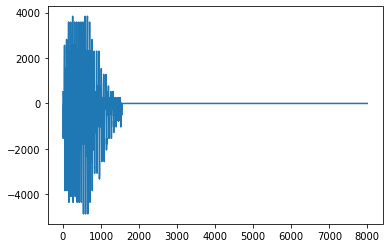

3
[8000]


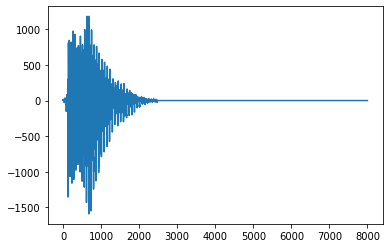

In [7]:

for waveform, label in fixed_train.skip(20).take(3):
    tf.print(label)
    tf.print(tf.shape(waveform))
    plt.figure()
    plt.plot(waveform)
    plt.show()
    # TODO: Show the waveforms with Matplotlib.

Next, we want to extract the short-time Fourier transforms of each waveform. A short-time Fourier transform is like a window that slides along the signal. At each point, it determines the frequency components present in the signal inside the window. This creates a varying estimate of what the signal sounds like over time in bins divided by frequency, which is closer to what the human ear actually hears!

Tensorflow provides a function, `tf.stft`, which lets you specify the size of the window and how far you move it each step. The code for making use of it is provided below:

In [8]:
@tf.function(autograph=False) 
# autograph=False means I have no "if" statements or loops and is slightly faster.
def get_spectrogram(waveform,label):
    # Take the short-time Fourier transform:
    spectrogram = tf.signal.stft(waveform,frame_length=255,frame_step=128)
    # Remove the imaginary components:
    spectrogram = tf.abs(spectrogram)
    # Make sure it looks like an image, so we can do 2D convolution on it
    spectrogram = tf.expand_dims(spectrogram,axis=-1)

    return spectrogram, label

We then apply this function to each sample in our datasets:

In [9]:
spec_train = fixed_train.map(get_spectrogram)
spec_val = fixed_val.map(get_spectrogram)
spec_test = fixed_test.map(get_spectrogram)

We can now pull out a few of these spectrograms to look at:

4
[61 129 1]


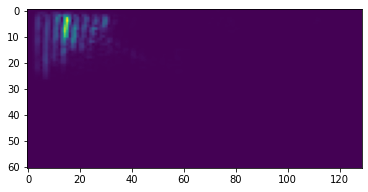

3
[61 129 1]


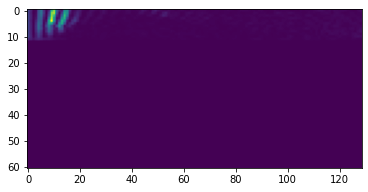

3
[61 129 1]


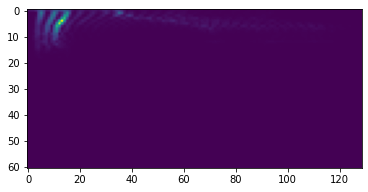

In [10]:
for spectrogram, label in spec_train.skip(20).take(3):
    tf.print(label)
    tf.print(tf.shape(spectrogram))
    # TODO: Show the spectrograms with Matplotlib.
    # Gotta remember to tf.squeeze() out that color dimension.
    plt.figure()
    plt.imshow(tf.squeeze(spectrogram))
    plt.show()

To make sure that our network is learning effectively (and doesn't get caught in a cycle of learning and unlearning something) we need to shuffle the data every time we come through for it. Luckily, Tensorflow Datasets have a nice `.shuffle()` method to help us out with that:

In [11]:
def shuffle_ds(ds):
    return ds.shuffle(ds.cardinality(),reshuffle_each_iteration=True)

We also want to train our networks with batches of data, to make best use of our computing resources, so we have a function to make those batches:

In [12]:
batch_size=64

def batch_ds(ds):
    return ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

Let's apply the shuffles and batching to our datasets to produce what we'll actually give to the optimizer:

In [13]:
# Shuffle before we batch to make sure we get different batches each run
train_ds = batch_ds(shuffle_ds(spec_train))
# Training and testing don't need shuffling.
# For them we don't care about order, just accuracy!
val_ds = batch_ds(spec_val)
test_ds = batch_ds(spec_test)

In [14]:
np_val = np.asarray(val_ds)
np_val

array(<PrefetchDataset shapes: ((None, 61, 129, 1), (None,)), types: (tf.float32, tf.int64)>,
      dtype=object)

Now we're ready to declare and train models!

# Your own model!

In [15]:
# TODO: Make a good ol' fasioned model
# When your model is ready, to train it you'll use something like
# history = my_model_name.fit(train_ds,epochs=24,validation_data=val_ds)
# Remember: Compile your model before training.
# Our labels are integers; which loss can convert a one-hot vector to an integer?

#Define Model


In [44]:
main_model = tf.keras.Sequential()
main_model.add(tf.keras.layers.Input(shape = (61,129,1)))
main_model.add(tf.keras.layers.Conv2D(32,3, activation='relu'))
main_model.add(tf.keras.layers.Conv2D(64,3, activation='relu'))
main_model.add(tf.keras.layers.Dropout(0.25))
main_model.add(tf.keras.layers.Flatten())
main_model.add(tf.keras.layers.Dense(64, activation='relu'))
main_model.add(tf.keras.layers.Dense(10))

main_model.summary()

main_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'])
hist_main = main_model.fit(train_ds, epochs=24, validation_data=val_ds)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 59, 127, 32)       320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 57, 125, 64)       18496     
_________________________________________________________________
dropout_5 (Dropout)          (None, 57, 125, 64)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 456000)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                29184064  
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 29,203,530
Trainable params: 29,203,530
Non-trainable params: 0
__________________________________________

# Loading others' bottoms

In [16]:
# TODO: Load bottoms, attach them to tops and train models
# tf.keras.models.load_model() sounds useful...
# Gotta keep their histories too, or at least the accuracy and loss data
model_A = tf.keras.models.load_model('/content/bottom_A.h5', compile=False)

model_A.trainable = True

new_model = tf.keras.Sequential()
new_model.add(tf.keras.layers.Input(shape = (61,129,1)))
new_model.add(model_A)
new_model.add(tf.keras.layers.Conv2D(32,3, activation='relu'))
new_model.add(tf.keras.layers.Conv2D(64,3, activation='relu'))
new_model.add(tf.keras.layers.Dropout(0.25))
new_model.add(tf.keras.layers.Flatten())
new_model.add(tf.keras.layers.Dense(64, activation='relu'))
new_model.add(tf.keras.layers.Dense(10))

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottom (Sequential)          (None, 12, 5, 32)         14988     
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 3, 32)         9248      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 1, 64)          18496     
_________________________________________________________________
dropout (Dropout)            (None, 8, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

In [17]:
new_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'])



In [18]:
hist_A = new_model.fit(train_ds, epochs=24, validation_data=val_ds)

Epoch 1/24
32/32 [==============================] - 59s 2s/step - loss: 2.1283 - accuracy: 0.2286 - val_loss: 0.9257 - val_accuracy: 0.7400
Epoch 2/24
32/32 [==============================] - 57s 2s/step - loss: 0.8001 - accuracy: 0.7518 - val_loss: 0.4811 - val_accuracy: 0.8640
Epoch 3/24
32/32 [==============================] - 56s 2s/step - loss: 0.3705 - accuracy: 0.8750 - val_loss: 0.3072 - val_accuracy: 0.9200
Epoch 4/24
32/32 [==============================] - 60s 2s/step - loss: 0.2375 - accuracy: 0.9371 - val_loss: 0.2774 - val_accuracy: 0.9120
Epoch 5/24
32/32 [==============================] - 57s 2s/step - loss: 0.1765 - accuracy: 0.9519 - val_loss: 0.1842 - val_accuracy: 0.9560
Epoch 6/24
32/32 [==============================] - 57s 2s/step - loss: 0.1462 - accuracy: 0.9539 - val_loss: 0.1791 - val_accuracy: 0.9560
Epoch 7/24
32/32 [==============================] - 57s 2s/step - loss: 0.0950 - accuracy: 0.9685 - val_loss: 0.1632 - val_accuracy: 0.9600
Epoch 8/24
32/32 [==

In [19]:
np.save('/content/hist_A.npy', hist_A.history)

In [20]:
model_B = tf.keras.models.load_model('/content/bottom_B.h5', compile=False)

model_B.trainable = True

new_model = tf.keras.Sequential()
new_model.add(tf.keras.layers.Input(shape = (61,129,1)))
new_model.add(model_B)
new_model.add(tf.keras.layers.Conv2D(32,3, activation='relu'))
new_model.add(tf.keras.layers.Conv2D(64,3, activation='relu'))
new_model.add(tf.keras.layers.Dropout(0.25))
new_model.add(tf.keras.layers.Flatten())
new_model.add(tf.keras.layers.Dense(64, activation='relu'))
new_model.add(tf.keras.layers.Dense(10))

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 12, 5, 32)         14988     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 3, 32)         9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 1, 64)          18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [21]:
new_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'])
hist_B = new_model.fit(train_ds, epochs=24, validation_data=val_ds)

Epoch 1/24
32/32 [==============================] - 58s 2s/step - loss: 2.1460 - accuracy: 0.2472 - val_loss: 1.1801 - val_accuracy: 0.5720
Epoch 2/24
32/32 [==============================] - 57s 2s/step - loss: 0.9329 - accuracy: 0.6830 - val_loss: 0.5769 - val_accuracy: 0.8160
Epoch 3/24
32/32 [==============================] - 57s 2s/step - loss: 0.4793 - accuracy: 0.8266 - val_loss: 0.4809 - val_accuracy: 0.8960
Epoch 4/24
32/32 [==============================] - 57s 2s/step - loss: 0.3071 - accuracy: 0.8997 - val_loss: 0.3527 - val_accuracy: 0.8880
Epoch 5/24
32/32 [==============================] - 57s 2s/step - loss: 0.2106 - accuracy: 0.9302 - val_loss: 0.3407 - val_accuracy: 0.9080
Epoch 6/24
32/32 [==============================] - 57s 2s/step - loss: 0.1751 - accuracy: 0.9400 - val_loss: 0.2216 - val_accuracy: 0.9480
Epoch 7/24
32/32 [==============================] - 57s 2s/step - loss: 0.1784 - accuracy: 0.9424 - val_loss: 0.1526 - val_accuracy: 0.9480
Epoch 8/24
32/32 [==

In [22]:
np.save('/content/hist_B.npy', hist_B.history)

# Non-trainable bottoms

In [23]:
# TODO: Load a bottom, set it untrainable, then attach it to a top.
# The attribute to set to False should be `modelname.trainable`
# Gotta keep its history too
model_C = tf.keras.models.load_model('/content/bottom_C.h5', compile=False)

model_C.trainable = False

new_model = tf.keras.Sequential()
new_model.add(tf.keras.layers.Input(shape = (61,129,1)))
new_model.add(model_C)
new_model.add(tf.keras.layers.Conv2D(32,3, activation='relu'))
new_model.add(tf.keras.layers.Conv2D(64,3, activation='relu'))
new_model.add(tf.keras.layers.Dropout(0.25))
new_model.add(tf.keras.layers.Flatten())
new_model.add(tf.keras.layers.Dense(64, activation='relu'))
new_model.add(tf.keras.layers.Dense(10))

new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottom (Sequential)          (None, 12, 5, 32)         14988     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 3, 32)         9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 1, 64)          18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 1, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [24]:
new_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'])
hist_C = new_model.fit(train_ds, epochs=24, validation_data=val_ds)

Epoch 1/24
32/32 [==============================] - 25s 649ms/step - loss: 2.2072 - accuracy: 0.2224 - val_loss: 1.5343 - val_accuracy: 0.5080
Epoch 2/24
32/32 [==============================] - 24s 645ms/step - loss: 1.3684 - accuracy: 0.5497 - val_loss: 0.9104 - val_accuracy: 0.7160
Epoch 3/24
32/32 [==============================] - 24s 643ms/step - loss: 0.8039 - accuracy: 0.7534 - val_loss: 0.6723 - val_accuracy: 0.7640
Epoch 4/24
32/32 [==============================] - 24s 644ms/step - loss: 0.5885 - accuracy: 0.8185 - val_loss: 0.4840 - val_accuracy: 0.8480
Epoch 5/24
32/32 [==============================] - 24s 644ms/step - loss: 0.4490 - accuracy: 0.8638 - val_loss: 0.4012 - val_accuracy: 0.8880
Epoch 6/24
32/32 [==============================] - 24s 644ms/step - loss: 0.3654 - accuracy: 0.8920 - val_loss: 0.3542 - val_accuracy: 0.8920
Epoch 7/24
32/32 [==============================] - 24s 642ms/step - loss: 0.3087 - accuracy: 0.9006 - val_loss: 0.2791 - val_accuracy: 0.9240

In [25]:
np.save('/content/hist_C.npy', hist_C.history)

In [26]:
model_fav = tf.keras.models.load_model('/content/bottom_A.h5', compile=False)

model_fav.trainable = False

new_model = tf.keras.Sequential()
new_model.add(tf.keras.layers.Input(shape = (61,129,1)))
new_model.add(model_fav)
new_model.add(tf.keras.layers.Conv2D(32,3, activation='relu'))
new_model.add(tf.keras.layers.Conv2D(64,3, activation='relu'))
new_model.add(tf.keras.layers.Dropout(0.25))
new_model.add(tf.keras.layers.Flatten())
new_model.add(tf.keras.layers.Dense(64, activation='relu'))
new_model.add(tf.keras.layers.Dense(10))

new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottom (Sequential)          (None, 12, 5, 32)         14988     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 3, 32)         9248      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 1, 64)          18496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 1, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [27]:
new_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'])
hist_fav = new_model.fit(train_ds, epochs=24, validation_data=val_ds)

Epoch 1/24
32/32 [==============================] - 25s 651ms/step - loss: 2.2011 - accuracy: 0.2065 - val_loss: 1.4493 - val_accuracy: 0.5400
Epoch 2/24
32/32 [==============================] - 24s 643ms/step - loss: 1.2484 - accuracy: 0.5955 - val_loss: 0.7661 - val_accuracy: 0.7840
Epoch 3/24
32/32 [==============================] - 24s 644ms/step - loss: 0.7381 - accuracy: 0.7471 - val_loss: 0.5356 - val_accuracy: 0.8280
Epoch 4/24
32/32 [==============================] - 24s 645ms/step - loss: 0.4521 - accuracy: 0.8590 - val_loss: 0.4317 - val_accuracy: 0.8720
Epoch 5/24
32/32 [==============================] - 24s 643ms/step - loss: 0.4006 - accuracy: 0.8679 - val_loss: 0.4116 - val_accuracy: 0.8720
Epoch 6/24
32/32 [==============================] - 24s 646ms/step - loss: 0.3273 - accuracy: 0.8838 - val_loss: 0.3803 - val_accuracy: 0.8960
Epoch 7/24
32/32 [==============================] - 24s 643ms/step - loss: 0.2579 - accuracy: 0.9173 - val_loss: 0.3142 - val_accuracy: 0.9080

In [28]:
np.save('/content/hist_fav.npy', hist_fav.history)

# Performance comparison

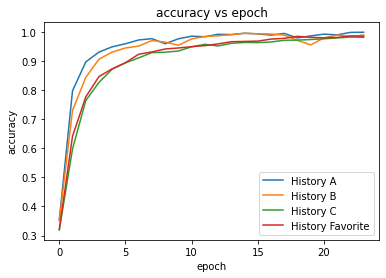

In [40]:
# TODO: Plot accuracies and losses of all five networks trained so far 
#  onto two plots:
# + one for accuracies
# + one for losses
# Gotta remember labels!
plt.plot(hist_A.history['accuracy'], label = 'History A')
plt.plot(hist_B.history['accuracy'], label = 'History B')
plt.plot(hist_C.history['accuracy'], label = 'History C')
plt.plot(hist_fav.history['accuracy'], label = 'History Favorite')
plt.title('accuracy vs epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

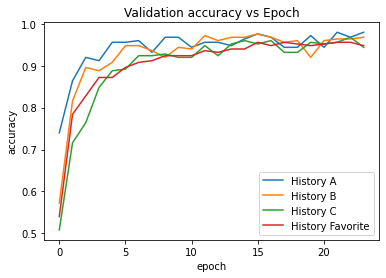

In [41]:
plt.plot(hist_A.history['val_accuracy'], label = 'History A')
plt.plot(hist_B.history['val_accuracy'], label = 'History B')
plt.plot(hist_C.history['val_accuracy'], label = 'History C')
plt.plot(hist_fav.history['val_accuracy'], label = 'History Favorite')
plt.title('Validation accuracy vs Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

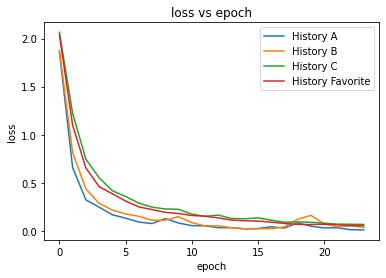

In [42]:
plt.plot(hist_A.history['loss'], label = 'History A')
plt.plot(hist_B.history['loss'], label = 'History B')
plt.plot(hist_C.history['loss'], label = 'History C')
plt.plot(hist_fav.history['loss'], label = 'History Favorite')
plt.title('loss vs epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

###Examine your plot from the Workflow.
(1 pts) Which network did best, in your eyes? Worst?

The network with Bottom A did best. The network with Bottom C did worst.

(1 pts) Did any networks seem to overfit to the data?

Bottom C network seemed to overfit to the data based on comparison with accuracy and validation accuracy.

(1 pts) Did the networks with pretrained bottoms have any surprising behaviour? Rapid initial growth? Starting at a higher first accuracy?

By analyzing at each epoch, it can be observed that the model with bottom A had a higher accuracy first at Epoch 4. Model with bottom B had a faster loss decline in comparison to the other models. 